In [2]:
from msclap import CLAP
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import os

In [8]:
kids = pd.read_csv("/bucket/data_collection/datasets/web_free_data/source/youtube_children_podcasts_122023/meta.csv")
kids_10k = kids.sample(1000, random_state=1)
kids_10k['class'] = 'child'
display(kids_10k)
kids_10k['filepath'][23018]

,srcFilename,sample_rate,init_seconds,end_seconds,audio_length,dstFolder,filename,dstFilename,filepath,dataset_name,s3_filepath,feature_min_delta_rmsdb,feature_speech_probability_on_min_delta_rmsdb,feature_speech_probability,class
23018,/bucket/data_collection/datasets/web_free_data...,44100,247.527938,251.527938,4.0,76,00023018.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,youtube_children_podcasts_122023,youtube_children_podcasts_122023/audios/076/00...,0.018021,0.609680,0.760261,child
20435,/bucket/data_collection/datasets/web_free_data...,44100,3348.527938,3352.527938,4.0,68,00020435.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,youtube_children_podcasts_122023,youtube_children_podcasts_122023/audios/068/00...,0.112015,0.943923,0.939302,child
22512,/bucket/data_collection/datasets/web_free_data...,48000,210.527938,214.527938,4.0,75,00022512.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,youtube_children_podcasts_122023,youtube_children_podcasts_122023/audios/075/00...,0.095098,0.920468,0.871707,child
3723,/bucket/data_collection/datasets/web_free_data...,44100,296.527938,300.527938,4.0,12,00003723.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,youtube_children_podcasts_122023,youtube_children_podcasts_122023/audios/012/00...,0.063807,0.592827,0.859006,child
35400,/bucket/data_collection/datasets/web_free_data...,48000,51.527938,55.527938,4.0,118,00035400.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,youtube_children_podcasts_122023,youtube_children_podcasts_122023/audios/118/00...,0.019152,0.787476,0.854660,child
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54444,/bucket/data_collection/datasets/web_free_data...,48000,1507.527938,1511.527938,4.0,181,00054444.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,youtube_children_podcasts_122023,youtube_children_podcasts_122023/audios/181/00...,0.048852,0.806863,0.915616,child
9192,/bucket/data_collection/datasets/web_free_data...,48000,52.527938,56.527938,4.0,30,00009192.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,youtube_children_podcasts_122023,youtube_children_podcasts_122023/audios/030/00...,0.027389,0.391419,0.657608,child
56565,/bucket/data_collection/datasets/web_free_data...,48000,1009.527938,1013.527938,4.0,188,00056565.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,youtube_children_podcasts_122023,youtube_children_podcasts_122023/audios/188/00...,0.084141,0.965113,0.818583,child
20464,/bucket/data_collection/datasets/web_free_data...,44100,3541.527938,3545.527938,4.0,68,00020464.wav,/bucket/data_collection/datasets/web_free_data...,/bucket/data_collection/datasets/web_free_data...,youtube_children_podcasts_122023,youtube_children_podcasts_122023/audios/068/00...,0.026061,0.689679,0.704980,child


'/bucket/data_collection/datasets/web_free_data/source/youtube_children_podcasts_122023/audios/076/00023018.wav'

In [30]:
adults = pd.read_csv("/bucket/data_collection/datasets/web_free_data/source/google_podcasts/meta.csv", index_col='Unnamed: 0')
display(adults)
adults = adults[adults['audio_length'] == 4.0]
adults_10k = adults.sample(1000, random_state=1)
adults_10k['class'] = 'adult'
display(adults_10k)
adults_10k['filepath'][53298]

,srcFilename,sample_rate,init_seconds,end_seconds,audio_length,dstFolder,filename,dstFilename,filepath,dataset_name,s3_filepath,feature_min_delta_rmsdb,feature_speech_probability_on_min_delta_rmsdb,feature_speech_probability
0,/bucket/data_collection/datasets/web_free_data...,44100,10.527938,22.527938,12.0,0,googlepodcasts_fb_clean_00000000.wav,web_free_data/source/google_podcasts/part1/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part1/audios/00000/googlepodca...,NaN,NaN,NaN
1,/bucket/data_collection/datasets/web_free_data...,44100,22.527938,34.527938,12.0,0,googlepodcasts_fb_clean_00000001.wav,web_free_data/source/google_podcasts/part1/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part1/audios/00000/googlepodca...,NaN,NaN,NaN
2,/bucket/data_collection/datasets/web_free_data...,44100,50.527938,62.527938,12.0,0,googlepodcasts_fb_clean_00000002.wav,web_free_data/source/google_podcasts/part1/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part1/audios/00000/googlepodca...,NaN,NaN,NaN
3,/bucket/data_collection/datasets/web_free_data...,44100,86.527937,98.527937,12.0,0,googlepodcasts_fb_clean_00000003.wav,web_free_data/source/google_podcasts/part1/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part1/audios/00000/googlepodca...,NaN,NaN,NaN
4,/bucket/data_collection/datasets/web_free_data...,44100,131.527938,143.527938,12.0,0,googlepodcasts_fb_clean_00000004.wav,web_free_data/source/google_podcasts/part1/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part1/audios/00000/googlepodca...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64228,/bucket/data_collection/datasets/web_free_data...,44100,1465.527938,1477.527938,12.0,28,googlepodcasts_fb_clean_00052045.wav,web_free_data/source/google_podcasts/part3/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part3/audios/00028/googlepodca...,NaN,NaN,NaN
64229,/bucket/data_collection/datasets/web_free_data...,44100,1647.527938,1659.527938,12.0,28,googlepodcasts_fb_clean_00052046.wav,web_free_data/source/google_podcasts/part3/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part3/audios/00028/googlepodca...,NaN,NaN,NaN
64230,/bucket/data_collection/datasets/web_free_data...,44100,1804.527938,1816.527938,12.0,28,googlepodcasts_fb_clean_00052047.wav,web_free_data/source/google_podcasts/part3/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part3/audios/00028/googlepodca...,NaN,NaN,NaN
64231,/bucket/data_collection/datasets/web_free_data...,44100,1851.527938,1863.527938,12.0,28,googlepodcasts_fb_clean_00052048.wav,web_free_data/source/google_podcasts/part3/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part3/audios/00028/googlepodca...,NaN,NaN,NaN


,srcFilename,sample_rate,init_seconds,end_seconds,audio_length,dstFolder,filename,dstFilename,filepath,dataset_name,s3_filepath,feature_min_delta_rmsdb,feature_speech_probability_on_min_delta_rmsdb,feature_speech_probability,class
53298,/bucket/data_collection/datasets/web_free_data...,44100,533.527938,537.527938,4.0,2,google_podcasts_50db_00000651.wav,web_free_data/source/google_podcasts/part5/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part5/audios/00002/google_podc...,0.010081,0.785233,0.703818,adult
53059,/bucket/data_collection/datasets/web_free_data...,44100,1750.527938,1754.527938,4.0,1,google_podcasts_50db_00000412.wav,web_free_data/source/google_podcasts/part5/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part5/audios/00001/google_podc...,0.009980,0.457493,0.670229,adult
54579,/bucket/data_collection/datasets/web_free_data...,44100,990.527938,994.527938,4.0,6,google_podcasts_50db_00001932.wav,web_free_data/source/google_podcasts/part5/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part5/audios/00006/google_podc...,-0.009180,0.483054,0.721825,adult
55129,/bucket/data_collection/datasets/web_free_data...,44100,563.527938,567.527938,4.0,8,google_podcasts_50db_00002482.wav,web_free_data/source/google_podcasts/part5/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part5/audios/00008/google_podc...,0.006358,0.866400,0.770957,adult
53041,/bucket/data_collection/datasets/web_free_data...,44100,3782.527938,3786.527938,4.0,1,google_podcasts_50db_00000394.wav,web_free_data/source/google_podcasts/part5/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part5/audios/00001/google_podc...,-0.004064,0.560180,0.546718,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53804,/bucket/data_collection/datasets/web_free_data...,44100,1357.527938,1361.527938,4.0,3,google_podcasts_50db_00001157.wav,web_free_data/source/google_podcasts/part5/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part5/audios/00003/google_podc...,0.005220,0.798644,0.900616,adult
54726,/bucket/data_collection/datasets/web_free_data...,44100,384.527938,388.527938,4.0,6,google_podcasts_50db_00002079.wav,web_free_data/source/google_podcasts/part5/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part5/audios/00006/google_podc...,0.007084,0.540184,0.712655,adult
54439,/bucket/data_collection/datasets/web_free_data...,44100,148.527938,152.527938,4.0,5,google_podcasts_50db_00001792.wav,web_free_data/source/google_podcasts/part5/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part5/audios/00005/google_podc...,0.003319,0.499201,0.816928,adult
53188,/bucket/data_collection/datasets/web_free_data...,44100,3431.527938,3435.527938,4.0,1,google_podcasts_50db_00000541.wav,web_free_data/source/google_podcasts/part5/aud...,/bucket/data_collection/datasets/web_free_data...,google_podcasts,google_podcasts/part5/audios/00001/google_podc...,0.005332,0.736731,0.681253,adult


KeyError: 1696

In [16]:
#Create single df 
df = pd.concat([adults_10k[['filepath', 'class']], kids_10k[['filepath', 'class']]])
df = kids_10k[['filepath', 'class']]
display(df)

,filepath,class
23018,/bucket/data_collection/datasets/web_free_data...,child
20435,/bucket/data_collection/datasets/web_free_data...,child
22512,/bucket/data_collection/datasets/web_free_data...,child
3723,/bucket/data_collection/datasets/web_free_data...,child
35400,/bucket/data_collection/datasets/web_free_data...,child
...,...,...
54444,/bucket/data_collection/datasets/web_free_data...,child
9192,/bucket/data_collection/datasets/web_free_data...,child
56565,/bucket/data_collection/datasets/web_free_data...,child
20464,/bucket/data_collection/datasets/web_free_data...,child


In [17]:
classes = df['class'].unique()

class_id_map = {name: i for i, name in enumerate(classes, 0)}
print(class_id_map)

prompt = 'The speaker is the age of a'
y = [prompt + x for x in classes]


{'child': 0}


In [18]:
# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=True)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

In [19]:
# Computing audio embeddings
y_preds, y_labels = [], []
print(os.getcwd())

for i in tqdm(range(len(df))):
    path, label = df.iloc[i]
    idx = class_id_map[label]
    #print(idx)
    one_hot_target = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=len(classes)+1)

    audio_embeddings = clap_model.get_audio_embeddings([path], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()

    y_preds.append(y_pred)
    y_labels.append(one_hot_target.detach().cpu().numpy())


/mounts/ud-data/jtaylor/a5f2c23d-7fb6-41a6-ac0c-3a2ffc02b992/data/acoustic_scene_classification/CLAP-main/examples


100%|██████████| 1000/1000 [01:22<00:00, 12.11it/s]


In [20]:
y_lab, y_pred = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
y_label_val = np.argmax(y_lab, axis=1)
y_pred_val = np.argmax(y_pred, axis=1)
acc = accuracy_score(np.argmax(y_lab, axis=1), np.argmax(y_pred, axis=1))
print('Accuracy {}'.format(acc))

Accuracy 1.0


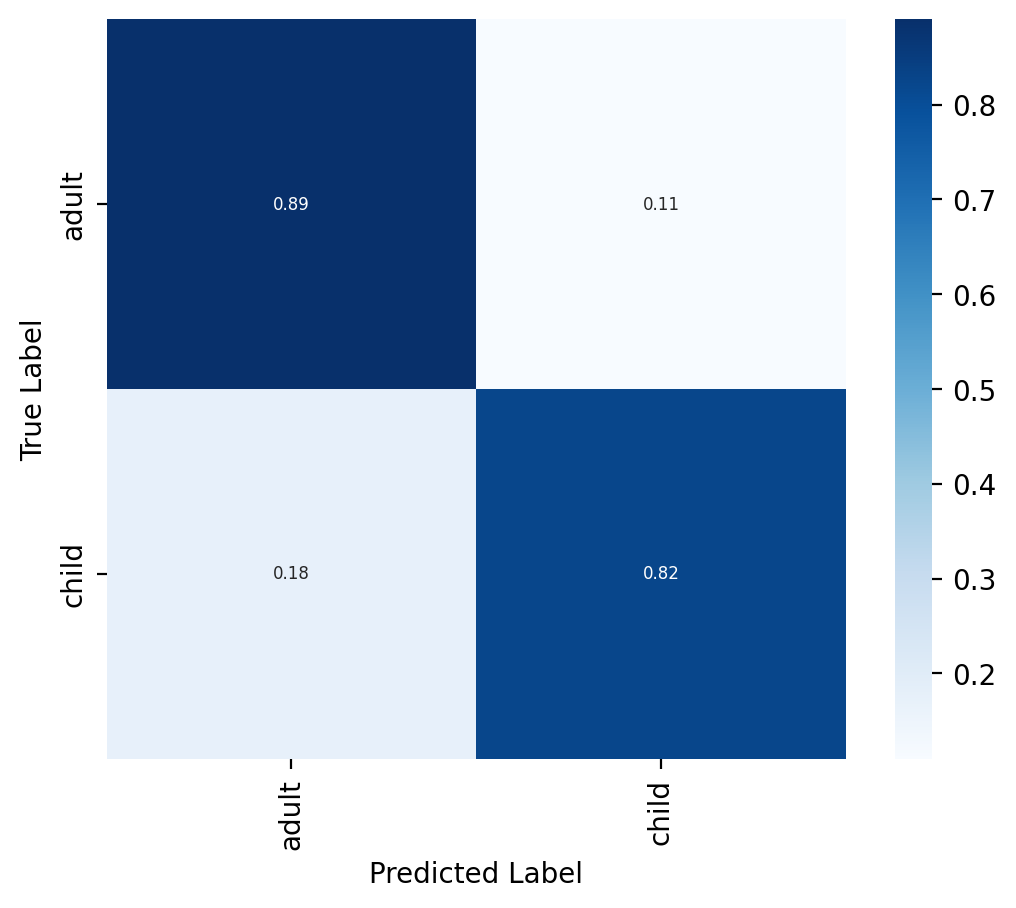

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# get confusion matrix
conf_matrix = confusion_matrix(y_label_val,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=classes, yticklabels=classes, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()

In [ ]:
/bucket/data_collection/datasets/web_free_data/source/youtube_children_podcasts_122023/meta.csv